In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
sys.path.append('..')
import os
import json
import time
import numpy as np
import argparse

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, DVILoss, DummyTemporalLoss
from singleVis.edge_dataset import VisDataHandler
from singleVis.trainer import VISTrainer
from singleVis.eval.evaluator import Evaluator
from singleVis.data import NormalDataProvider
from trustVis.sampeling import CriticalSampling
from singleVis.spatial_edge_constructor import Trustvis_SpatialEdgeConstructor, TrustvisTemporalSpatialEdgeConstructor

from singleVis.utils import _construct_fuzzy_complex

from singleVis.projector import VISProjector

import torch.nn.functional as F
########################################################################################################################
#                                                      PARAMETERS                                                   #
########################################################################################################################
"""This serve as an example of DeepVisualInsight implementation in pytorch."""
VIS_METHOD = "DVI" #

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################


parser = argparse.ArgumentParser(description='Process hyperparameters...')

# get workspace dir
current_path = os.getcwd()

parent_path = os.path.dirname(current_path)

new_path = os.path.join(parent_path, 'training_dynamic')


CONTENT_PATH = '/home/yifan/0ExpMinist/Default/02'
sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

EPOCH_START = 1
EPOCH_END = 1
epoch = EPOCH_START
# EPOCH_START = 1
# EPOCH_END = 50
EPOCH_PERIOD = 1

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = 1
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = 0
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]
VIS_MODEL_NAME = 'trustvis_tempo_fine_tune_conf' ### saved_as VIS_MODEL_NAME.pth
# Define hyperparameters
GPU_ID = 0
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")
print("device", DEVICE)           

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-21 13:38:37.722294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 13:38:38.263761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-21 13:38:38.263807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

device cuda:0
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 565.95it/s]


Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 6180.67it/s]


conf_error number: 4460
Successfully load the DVI visualization model for iteration 1
Computing decision regions ...
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1
grid_samples (160000, 512)


100%|██████████| 800/800 [00:00<00:00, 3188.74it/s]


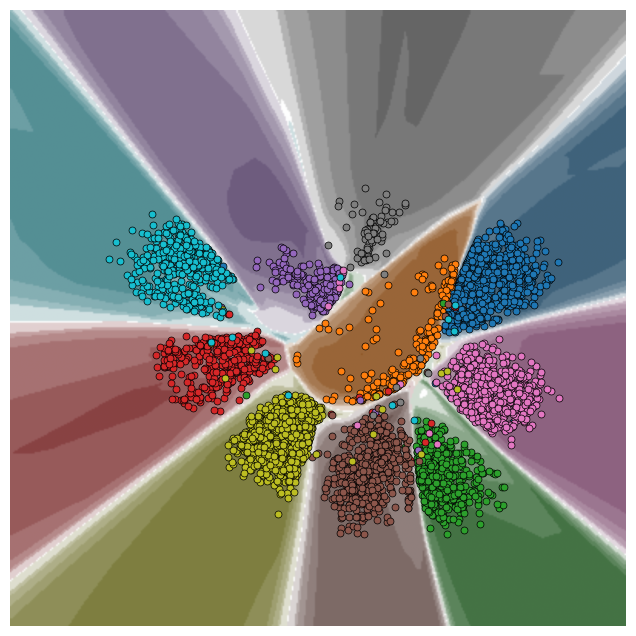

In [2]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)
path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)

train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])

pred = data_provider.get_pred(epoch, train_data)
new_pred_Res = pred.argmax(axis=1)

emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
conf_error = []
for i in range(len(diff)):
    if abs(diff[i] - inv_diff[i]) > 0.3:
        conf_error.append(i)
print("conf_error number:", len(conf_error))
# from singleVis.eval.evaluate import *
# val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
vis = visualizer(data_provider, projector, 400, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [3]:
from singleVis.utils import get_confidence_error_pairs
vis = visualizer(data_provider, projector, 400, "tab10")
conf_error,neg_grids,pos_grids = get_confidence_error_pairs(data_provider,epoch,projector,vis,0.3,400)

100%|██████████| 300/300 [00:00<00:00, 6192.87it/s]


get org pred
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 6092.56it/s]


get inv pred
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1
conf_error number: 4617 400
negative pairs: (4617, 15, 2)
positive pairs: (4617, 15, 2)


In [51]:
#### next we will retrain the model that freeze decoder: inv_grid is fixed. 

In [4]:
spatial_cons = Trustvis_SpatialEdgeConstructor(data_provider, epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS, net)
edge_to, edge_from, probs, pred_probs, feature_vectors, attention = spatial_cons.construct()

train data (60000, 512)


100%|██████████| 300/300 [00:00<00:00, 6136.60it/s]

Sun Apr 21 13:40:25 2024 Building RP forest with 17 trees


Sun Apr 21 13:40:26 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Gradients calculation: 46.00 seconds	softmax with temperature: 0.00 seconds


In [5]:
from singleVis.losses import UmapLoss_refine_conf, ReconstructionLoss, DVILoss, DummyTemporalLoss
temporal_loss_fn = DummyTemporalLoss(DEVICE)
recon_loss_fn = ReconstructionLoss(beta=1.0)
 
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
state_dict =  torch.load(os.path.join(CONTENT_PATH, "Model","Epoch_{}".format(epoch),"{}.pth".format(VIS_MODEL_NAME)))["state_dict"]
model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
pred_list = data_provider.get_pred(epoch, feature_vectors)
dataset = VisDataHandler(edge_to, edge_from, feature_vectors, attention, pred_probs,pred_list)
        
n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(pred_probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(pred_probs, n_samples, replacement=True)
    edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)

for i in range(3):
    umap_loss_fn = UmapLoss_refine_conf(negative_sample_rate, DEVICE, data_provider, epoch,net, conf_error, neg_grids,pos_grids,100, _a, _b,  repulsion_strength=1.0)
    criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)

    conf_error,neg_grids,pos_grids = get_confidence_error_pairs(data_provider,epoch,projector,vis,0.2,400)      
    trainer = VISTrainer(model,criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)
    trainer.train(PATIENT, 1,data_provider,epoch,True,False)

        # save result
save_dir = data_provider.model_path
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
trainer.save(save_dir=save_dir, file_name="{}".format('adjust_conf_vis'))


100%|██████████| 300/300 [00:00<00:00, 6184.43it/s]


get org pred
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1


100%|██████████| 300/300 [00:00<00:00, 6109.31it/s]


get inv pred
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1
conf_error number: 5000 400


100%|██████████| 300/300 [00:00<00:00, 5485.02it/s]


Successfully load the DVI visualization model for iteration 1
[23, 24, 77, 174, 201, 416, 484, 492, 783, 835, 871, 951, 1052, 1084, 1131, 1148, 1321, 1405, 1445, 1450, 1458, 1496, 1601, 1640, 1700, 1703, 1716, 1786, 1859, 2355, 2374, 2572, 2583, 2594, 2762, 2870, 2938, 3004, 3068, 3103, 3111, 3306, 3345, 3412, 3592, 3602, 3644, 3733, 3758, 3800, 4069, 4105, 4109, 4120, 4286, 4487, 4502, 4554, 4557, 4577, 4696, 4810, 4900, 4950, 4953, 4960, 5012, 5168, 5174, 5271, 5304, 5336, 5351, 5375, 5520, 5570, 5850, 5882, 5915, 5983, 6002, 6003, 6062, 6181, 6247, 6384, 6443, 6499, 6702, 6870, 6880, 6925, 7020, 7160, 7222, 7393, 7411, 7532, 7574, 7689, 7877, 8070, 8160, 8185, 8332, 8423, 8471, 8543, 8778, 8985, 8987, 9221, 9365, 9378, 9393, 9609, 9678, 9930, 10169, 10223, 10365, 10458, 10545, 10624, 10638, 10719, 11057, 11178, 11275, 11287, 11445, 11537, 11543, 11604, 11637, 11857, 11943, 12038, 12136, 12166, 12207, 12356, 12532, 12807, 12885, 13259, 13260, 13392, 13398, 13630, 13657, 13674, 13700,

100%|██████████| 300/300 [00:00<00:00, 5538.74it/s]


conf_error number: 3677
Sat Apr 20 21:03:50 2024 Building RP forest with 17 trees
Sat Apr 20 21:03:51 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Apr 20 21:03:53 2024 Building RP forest with 17 trees
Sat Apr 20 21:03:53 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
nn 1.8886833333333333
Successfully load the DVI visualization model for iteration 1
Computing decision regions ...
Successfully load the DVI visualization model for iteration 1
Successfully load the DVI visualization model for iteration 1
grid_samples (640000, 512)


100%|██████████| 3200/3200 [00:03<00:00, 914.43it/s] 


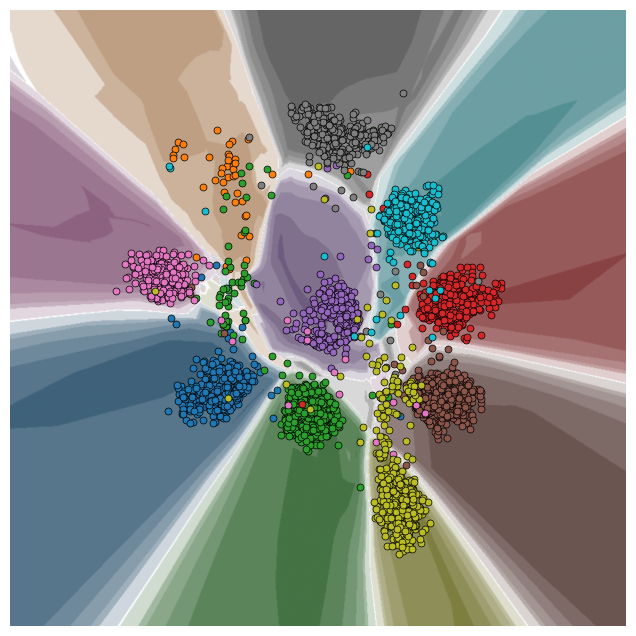

In [9]:
projector = VISProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='adjust_conf_vis', device=DEVICE)
# print('diff',diff[[[492, 783, 835, 871, 951, 1052,]]])

path = "/home/yifan/dataset/case_study_mnist_backdoor/clean_label.json"
with open(path, "r") as f:
    clean_label = json.load(f)
    
with open("/home/yifan/dataset/case_study_mnist_backdoor/noisy_label.json", "r") as f:
    noise_label = json.load(f)

noise_indicates = []
for i in range(len(clean_label)):
    if clean_label[i] != noise_label[i]:
        noise_indicates.append(i)

save_dir = os.path.join(data_provider.content_path, VIS_MODEL_NAME)
train_data = data_provider.train_representation(epoch)
labels = data_provider.train_labels(epoch)
train_data = train_data.reshape(train_data.shape[0],train_data.shape[1])
pred = data_provider.get_pred(epoch, train_data)
# pred = data_provider.get_pred(epoch,train_data)
new_pred_Res = pred.argmax(axis=1)
emb = projector.batch_project(epoch,train_data)
indicates = noise_indicates
print(indicates)
indicates = [492, 783, 835, 871, 951, 1052,]

sort_preds = np.sort(pred, axis=1)
diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])

inv = projector.batch_inverse(epoch, emb)
inv_pred = data_provider.get_pred(epoch, inv)
inv_sort_preds = np.sort(inv_pred, axis=1)
inv_diff = (inv_sort_preds[:, -1] - inv_sort_preds[:, -2]) / (inv_sort_preds[:, -1] - inv_sort_preds[:, 0])
# conf_error = []
# for i in range(len(diff)):
#     if abs(diff[i] - inv_diff[i]) > 0.3:
#         conf_error.append(i)
print("conf_error number:", len(conf_error))
from singleVis.visualizer import visualizer
now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
from singleVis.eval.evaluate import *
val = evaluate_proj_nn_perseverance_knn(train_data, emb, n_neighbors=15, metric="euclidean")
print("nn",val)
vis = visualizer(data_provider, projector, 800, "tab10")
vis.savefig_custom(epoch, path=os.path.join(save_dir, "{}_{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD,now)),
            pred=new_pred_Res[conf_error],
            train_labels=new_pred_Res[conf_error], 
            embedding=emb[conf_error])

In [14]:
val

1.41875

In [10]:
k=0
for i in range(len(conf_error)):
    index = conf_error[i]
    if abs(diff[index]-inv_diff[index]) > 0.3:
        k=k+1
print("current error:{}/{}".format(k,len(conf_error)))

current error:1426/3677


In [11]:
k=0
for i in range(len(train_data)):
    if abs(diff[i]-inv_diff[i]) > 0.3:
        k=k+1
print("total conf error:{}/{}".format(k,len(train_data)))

total conf error:1458/60000


In [12]:
k=0
inv_pred_Res = inv_pred.argmax(axis=1)
for i in range(len(inv_pred_Res)):
    if inv_pred_Res[i] != new_pred_Res[i]:
        k=k+1
k

295